# Set up Workspace

In [1]:
import sys
sys.path.append('../')

In [2]:
######################## Load modules ###################################
%matplotlib inline
import sys
import importlib
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
from scipy import stats

from plants_and_TCR.analysis_parameters import directory_information
from plants_and_TCR.analysis_parameters import params
from plants_and_TCR.analysis_parameters import get_CMIP_info
from plants_and_TCR.analyze_data import grab_cmip_dataset
from plants_and_TCR.analyze_data import moving_average as movingaverage

####################### Set up directory structure ######################
PATH_REGRIDDED_DATA = directory_information.DIR_PROCESSED_DATA
PATH_FIGURES = directory_information.DIR_OUTPUT_FIGURES

In [3]:
from plants_and_TCR.analysis_parameters import params
DEFAULT_VARNAME = params.DEFAULT_VARNAME
runnames_all = params.RUNNAMES_ALL

dir_CMIPdicts = directory_information.DIR_DATA_DICTIONARIES
CMIP_DICT = pickle.load(open(dir_CMIPdicts+'cmip_dict.pickle',"rb"))

In [4]:
# Load precalculated
DIR_TCR_DICT = directory_information.DIR_TCR_DICT
TCR_DICT = pickle.load(open(DIR_TCR_DICT+'TCR_dict.pickle', "rb"))

### Calculate Physiological contribution to TCR and T140

In [5]:
from plants_and_TCR.analyze_data import make_tcr_dataset
ds_tcr = make_tcr_dataset.make_tcr_dataset(TCR_DICT,
                                           end_yr=70,
                                           varname='tas',
                                           average_type='global',
                                           tcr_types=['TOT-RAD','TOT'])

ds_t140 = make_tcr_dataset.make_tcr_dataset(TCR_DICT,
                                            end_yr=130,
                                            varname='tas',
                                            average_type='global',
                                            tcr_types=['TOT-RAD','TOT'])

tcr_modelnames = ds_tcr.index.values

### Make Histograms

In [6]:
def get_baseline_values(modelname, varname=DEFAULT_VARNAME, runname='piControl',cmip_dict=CMIP_DICT, area_avg=None):
    pi_control_ds = grab_cmip_dataset.grab_cmip_dataset(cmip_dict,
                                                        modelname,
                                                        runname,
                                                        varname)
    if pi_control_ds is not None:
        pi_control = pi_control_ds[DEFAULT_VARNAME]
        cell_area = CMIP_DICT[modelname+'_'+'areacella']['areacella']
        area_weights = cell_area/cell_area.sum(dim=['lat','lon']).values
        
        land_frac = CMIP_DICT[modelname +'_sftlf']['sftlf'].reindex_like(cell_area, method='nearest', tolerance=0.001) # in values of 0 to 100
        glac_frac = CMIP_DICT[modelname +'_sftgif']['sftgif'].reindex_like(cell_area, method='nearest', tolerance=0.001)
        
        land_area = cell_area*(land_frac/100)*(1-(glac_frac/100))
        land_area_weights = land_area/land_area.sum(dim=['lat','lon']).values
        
        if area_avg =='land':
            pi_control_weighted = pi_control*land_area_weights
        elif ((area_avg == None) or (area_avg == 'global')):
            pi_control_weighted = pi_control*area_weights
        pi_control_global = pi_control_weighted.sum(dim=['lat','lon'])
        baseline = pi_control_global.mean(dim='time').values
        baseline_avgs = movingaverage.movingaverage(pi_control_global, 20*12) - baseline
    else:
        baseline_avgs=None
        baseline_avgs_years=None
        
    return baseline_avgs

In [7]:
modelnames = ['bcc-csm1-1','CanESM2','CESM1-BGC',
              'BCC-CSM2-MR','CanESM5','CESM2',
              'GFDL-ESM2M','HadGEM2-ES','IPSL-CM5A-LR',
              'GFDL-ESM4','UKESM1-0-LL','IPSL-CM6A-LR', 
              'NorESM1-ME','MPI-ESM-LR','',
              'NorESM2-LM','MPI-ESM1-2-LR','ACCESS-ESM1-5',
              '','','',
              'CNRM-ESM2-1','GISS-E2-1-G', 'MIROC-ES2L']

In [8]:
tcr_modelnames = ds_tcr.index.values

In [9]:
FIGURE_PATH = directory_information.DIR_OUTPUT_FIGURES
FONTSIZE=25
def plot_histograms(binnum, xlims,
                    varname=DEFAULT_VARNAME,
                    tcr=None,
                    avg_type=None):
    """Add docstring"""
    fig = plt.figure(figsize=(48, 24.5))
    mpl.rcParams.update({'font.size': FONTSIZE})
    mpl.rc('xtick', labelsize=FONTSIZE) 
    mpl.rc('ytick', labelsize=FONTSIZE) 
    ind=0
    for m in range(0, len(modelnames)):
        modelname = modelnames[m]  
        print(modelname)
        baseline_avgs = get_baseline_values(modelname, area_avg=avg_type)
        
        if baseline_avgs is not None:
            #----------Calculate Detrended Baseline
            times = np.arange(0,len(baseline_avgs))
            [slope, intercept, _, _, _] = stats.linregress(times, baseline_avgs)
            linearfit = slope*(times)+intercept
            detrended_baseline_avgs = baseline_avgs - linearfit
            print(np.round(np.std(detrended_baseline_avgs),3))

            #------------Make Subplot---------------------
            plt.subplot(4, 6, ind+1)
            plt.hist(baseline_avgs, bins=binnum, alpha=0.7, color='mediumblue')
            plt.hist(detrended_baseline_avgs, bins=10, alpha=0.5, color='lightgray')

            plt.axvline(0, color='k', linestyle='dashed', linewidth=1)
            
            if modelname in tcr_modelnames:
                tcr = ds_tcr['TOT-RAD'][modelname]
                t140 = ds_t140['TOT-RAD'][modelname]
                plt.axvline(tcr, color='red', linestyle='dotted', linewidth=3)
                plt.axvline(t140, color='red', linestyle='solid', linewidth=3)
            
            plt.title(modelname, fontsize=FONTSIZE+10)
            plt.xlim(xlims)
            if m in {12, 13, 8, 21, 22, 23}:
                plt.xlabel('20-year Mean  \n Temp. Anomaly', fontsize=FONTSIZE)
            if m in {0, 6, 12, 21}:
                plt.ylabel('Number of Years', fontsize=FONTSIZE)
        else:
            print('no data for '+modelname)
        ind = ind+1
    
    fig.subplots_adjust(hspace=.3)
    plt.show()
    fig.savefig(FIGURE_PATH +'piControl_variability_histograms'+'.png', bbox_inches='tight')
    return fig

bcc-csm1-1
0.059
CanESM2
0.035
CESM1-BGC
0.033
BCC-CSM2-MR
0.142
CanESM5
0.048
CESM2
0.062
GFDL-ESM2M
0.047
HadGEM2-ES
0.085
IPSL-CM5A-LR
0.044
GFDL-ESM4
0.06
UKESM1-0-LL
0.056
IPSL-CM6A-LR
0.092
NorESM1-ME
0.024
MPI-ESM-LR
0.04

_piControl_tas not in the dictionary
no data for 
NorESM2-LM
0.059
MPI-ESM1-2-LR
0.023
ACCESS-ESM1-5
0.054

_piControl_tas not in the dictionary
no data for 

_piControl_tas not in the dictionary
no data for 

_piControl_tas not in the dictionary
no data for 
CNRM-ESM2-1
0.13
GISS-E2-1-G
0.023
MIROC-ES2L
0.037


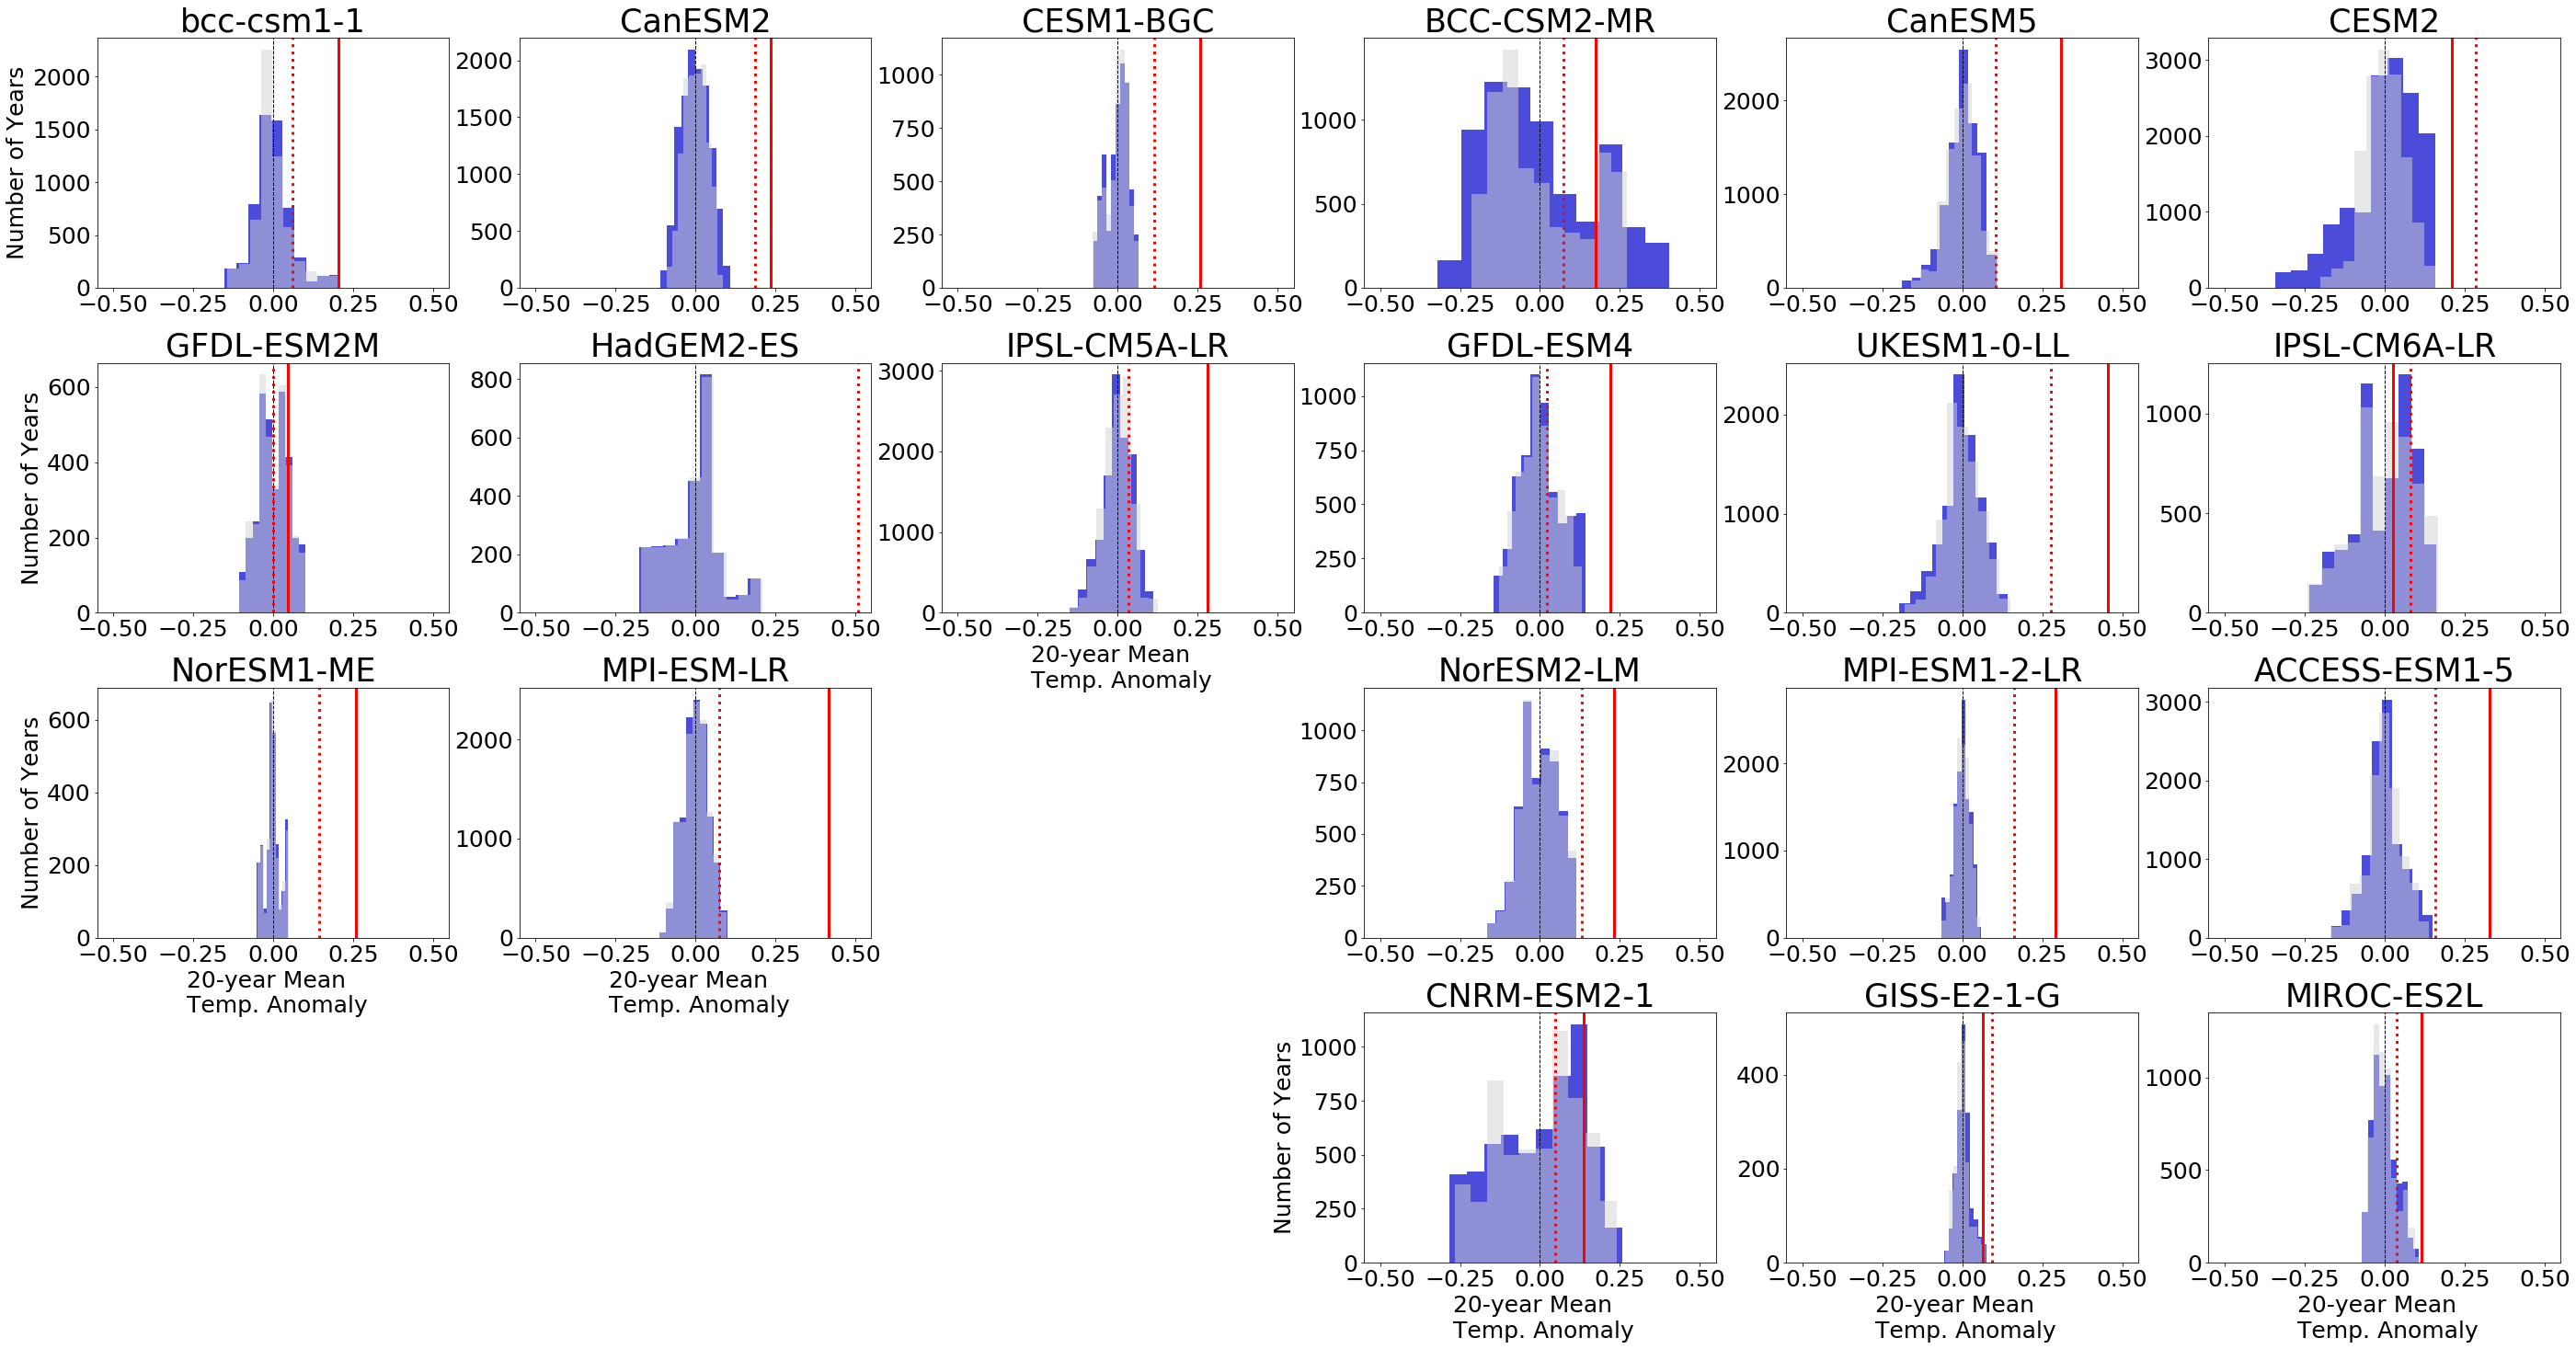

In [10]:
fig = plot_histograms(binnum=10, xlims=[-0.55,0.55],avg_type=None)